In [1]:

import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np 
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from autoattack import AutoAttack
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
dir = os.getcwd()
ROOT = os.path.dirname(dir)
sys.path.append(ROOT)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from models import resnet
from dataset import ID_OOD_dataloader

PATH = os.getcwd()

> ## Load Model Parameters

In [2]:
def load_model_param(model, model_name):
    MODEL_PATH = "models_pth/best_model_weights_" + model_name + ".pth"
    MODEL_PATH = os.path.join(PATH, MODEL_PATH)
    model_state_dict = torch.load(MODEL_PATH, weights_only=True)
    model.load_state_dict(model_state_dict)
    return model

> ## Measure and Print Method Performance with AUROC, FPR@95TPR, Detection Error 

In [3]:
def get_measures(conf_id, conf_ood):
    
    y_true = np.array([1] * len(conf_id) + [0] * len(conf_ood))
    y_score = np.concatenate((conf_id, conf_ood), axis=0)
    auroc = roc_auc_score(y_true, y_score)
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    fpr_at_95_tpr = fpr[np.argmax(tpr >= 0.95)]
    detection_errors = 0.5 * (1 - tpr + fpr)
    detection_errors = detection_errors.min()
    
    return {
        'auroc': auroc,
        'fpr_at_95_tpr': fpr_at_95_tpr,
        'detection_errors': detection_errors
    }

In [4]:
def print_metrics(measures):
    print("AUROC: {:.4f}".format(measures['auroc']))
    print("FPR at 95% TPR: {:.4f}".format(measures['fpr_at_95_tpr']))
    print("Detection Errors: {:.4f}".format(measures['detection_errors']))

> ## Visualization by ROC curve and KDE

In [5]:
def ROC_visualization(method, model_name, case, conf_id, conf_ood, measures):
    y_true = np.array([1] * len(conf_id) + [0] * len(conf_ood))
    y_score = np.concatenate((conf_id, conf_ood), axis=0)
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    
    NAME = method + "_" + model_name + case
    VISUAL_PATH = os.path.join(PATH, NAME)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.4f})'.format(measures['auroc']))
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.grid()
    plt.savefig(VISUAL_PATH + '.png')

In [6]:
def KDE_visualization(conf_id, conf_ood):
    xmin = min(conf_id.min(), conf_ood.min())
    xmax = max(conf_id.max(), conf_ood.max())
    xs = np.linspace(xmin, xmax, 200)

    # KDE Plot
    plt.figure(figsize=(8, 5))
    sns.kdeplot(conf_id, label="In-Dist", fill=True, alpha=0.4, color="blue")
    sns.kdeplot(conf_ood, label="Out-Dist", fill=True, alpha=0.4, color="orange")
    plt.title("KDE")
    plt.ylabel("Density")
    plt.xlim(xmin, xmax)
    plt.legend()
    plt.grid(True)
    plt.show()

> ## ODIN Method

In [7]:
def odin_score(model, x, temperature=1, magnitude=0.00005, std=(0.2675, 0.2565, 0.2761)):
    '''
    model should return logits
    x : batch size, 3, 32, 32 => CIFAR-100(ID), SVHN(OOD)
    temperature : temperature scaling
    magnitude : perturbation magnitude (epsilon)
    std : normalized std used in training (we set 0.2675, 0.2565, 0.2761)
    '''
    model.eval()
    # Achieve Input-Preprocessing, set input required_grad=True
    x.requires_grad=True
    logits, _ = model(x)
    logits = logits / temperature
    preds = logits.argmax(dim=1)
    
    loss = F.cross_entropy(logits, preds)
    loss.backward()
    
    grad = x.grad.data
    for c in range(3):
        grad[:, c] = grad[:, c] / std[c]
    grad_sign = grad.sign()
    
    x_perturbed = x - magnitude * grad_sign
    x_perturbed = x_perturbed.detach()
    
    logits, _ = model(x_perturbed)
    logits = logits / temperature
    softmax_conf = F.softmax(logits, dim=1)
    odin_confidence, _ = torch.max(softmax_conf, dim=1)
    
    return odin_confidence.detach().cpu().numpy()


> ## Mahalanobis-distance based Score

In [8]:
def estimate_class_stats_cholesky(model, id_dataset, feature_layers=["feats[2]"]):
    '''
    Computing the Mahalanobis distance-based confidence score with feature ensemble, also using the Tikhonov regularization and Cholesky decomposition
    '''
    model.eval()
    tik_factor = 0.09
    class_means_dict = {}
    precision_dict = {}
    
    feats_by_layer = {layer: defaultdict(list) for layer in feature_layers}
    all_feats_by_layer = {layer: [] for layer in feature_layers}
    
    with torch.no_grad():
        for x, y in id_dataset:
            x, y = x.to(device), y.to(device)
            _, feats = model(x)
            
            for layer in feats_by_layer:
                idx = int(layer.split("[")[1].split("]")[0])
                f = feats["feats"][idx]
                # (Batch, Channel, Height, Width) 이렇게 들어감
                # Squeeze로 (Batch, Channel)
                f = F.adaptive_avg_pool2d(f, 1)
                f = f.squeeze(-1).squeeze(-1)
                for i in range(f.size(0)):
                    vec = f[i].cpu()
                    label = y[i].item()
                    feats_by_layer[layer][label].append(vec)
                    all_feats_by_layer[layer].append(vec)

    for layer in feature_layers:
        # Per Class Average
        class_means = {}
        for cls, vecs in feats_by_layer[layer].items():
            mat = torch.stack(vecs)
            class_means[cls] = mat.mean(dim=0)
        class_means_dict[layer] = class_means
        
        # Total Covariance and precision
        all_feats = torch.stack(all_feats_by_layer[layer])
        mean = all_feats.mean(dim=0, keepdim=True)
        diff = all_feats - mean
        cov = diff.T @ diff / (diff.size(0) - 1)
        cov += tik_factor * torch.eye(cov.shape[0])
        L = torch.linalg.cholesky(cov)
        precision = torch.cholesky_inverse(L)
        precision_dict[layer] = precision
    
    return class_means_dict, precision_dict

In [9]:
def mahalanobis_best_layer_score_cholesky(model, x, class_means_dict, precision_dict, feature_layers=["feats[2]"]):
    model.eval()
    with torch.no_grad():
        _, feats = model(x)
        all_layer_scores = []
        
        for layer in feature_layers:
            idx = int(layer.split("[")[1].split("]")[0])
            feat = feats["feats"][idx]
            feat = F.adaptive_avg_pool2d(feat, 1).squeeze(-1).squeeze(-1) # B, C 
            
            class_means = class_means_dict[layer]
            precision = precision_dict[layer] # C, C
            precision = precision.to(device)
            
            scores = []
            for f in feat:
                min_dist = float("inf")
                for c in class_means:
                    class_means[c] = class_means[c].to(device)
                    delta = f - class_means[c]
                    dist = torch.matmul(torch.matmul(delta, precision), delta.T).item()
                    if dist < min_dist:
                        min_dist = dist
                scores.append(min_dist)
            all_layer_scores.append(torch.tensor(scores))
            
        all_layer_scores = torch.stack(all_layer_scores, dim=0)
        # best_scores = -torch.min(all_layer_scores, dim=0).values
        best_scores = -torch.min(all_layer_scores, dim=0).values
    return best_scores.detach().cpu().numpy()
            

In [ ]:
from sklearn.linear_model import LogisticRegression

# def train_fusion_classifier(odin_conf_id, odin_conf_ood, mal_conf_id, mal_conf_ood):
#     x = np.vstack([
#         np.stack([odin_conf_id, mal_conf_id], axis=1),
#         np.stack([odin_conf_ood, mal_conf_ood], axis=1),
#     ])
#     y = np.array([1] * len(odin_conf_id) + [0] * len(odin_conf_ood))
    
#     x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.7)

#     scaler = MinMaxScaler()
#     x_train = scaler.fit_transform(x_train)
#     x_test = scaler.transform(x_test)
    
#     clf = LogisticRegression()
#     clf.fit(x_train, y_train)
    
#     y_score = clf.predict_proba(x_test)[:, 1]
#     conf_id = y_score[y_test == 1]
#     conf_ood = y_score[y_test == 0]
    
#     return conf_id, conf_ood

def train_fusion_classifier(odin_conf_id, odin_conf_ood, mal_conf_id, mal_conf_ood, alpha=0.7):
    """
    alpha: weight for ODIN score, (1 - alpha) for Mahalanobis
    """

    scaler = MinMaxScaler()
    all_odin = np.concatenate([odin_conf_id, odin_conf_ood]).reshape(-1, 1)
    all_maha = np.concatenate([mal_conf_id, mal_conf_ood]).reshape(-1, 1)
    odin_norm = scaler.fit_transform(all_odin).flatten()
    maha_norm = scaler.fit_transform(all_maha).flatten()

    n_id = len(odin_conf_id)
    odin_id_norm = odin_norm[:n_id]
    odin_ood_norm = odin_norm[n_id:]
    maha_id_norm = maha_norm[:n_id]
    maha_ood_norm = maha_norm[n_id:]

    fusion_id = alpha * odin_id_norm + (1 - alpha) * maha_id_norm
    fusion_ood = alpha * odin_ood_norm + (1 - alpha) * maha_ood_norm

    return fusion_id, fusion_ood

In [11]:
class LogitsWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def forward(self, x):
        logits, _ = self.model(x)
        return logits

In [12]:
def fgsm_attack(model, x, y, epsilon=0.01):
    x.requires_grad = True
    logits, _ = model(x)
    loss = F.cross_entropy(logits, y)
    loss.backward()
    
    x_adv = x + epsilon * x.grad.data.sign()
    return x_adv.detach()

def pgd_attack(model, x, y, epsilon=0.01, alpha=0.01, steps=10):
    x_orig = x.detach()
    x_adv = x.clone().detach().requires_grad_(True)
    
    for _ in range(steps):
        logits, _ = model(x_adv)
        loss = F.cross_entropy(logits, y)
        loss.backward()
        x_adv.data += alpha * x_adv.grad.data.sign()
        x_adv.data = torch.max(torch.min(x_adv, x_orig + epsilon), x_orig - epsilon)
        x_adv.data = torch.clamp(x_adv.data, 0, 1)
        x_adv.grad.zero_()
    return x_adv.detach()

def autoattack_eval(model, x, y, norm='L2'):
    adversary = AutoAttack(LogitsWrapper(model), norm=norm, eps=0.5 if norm=='L2' else 8/255, version='standard')
    adversary.batch_size = 16
    return adversary.run_standard_evaluation(x, y)


In [13]:
def save_metrics_to_txt(avg_metrics, det_method, option, model_name, save_path="detection_results.txt"):
    """
    Save average metrics to a txt file.
    """
    output_str = (
        f"[OPTION]: {option}"
        f"[{det_method.upper()}] Mean AUROC: {avg_metrics['auroc']:.4f}, "
        f"FPR@95TPR: {avg_metrics['fpr_at_95_tpr']:.4f}, "
        f"Detection Error: {avg_metrics['detection_errors']:.4f}"
    )
    save_path = model_name + "_" + save_path
    RESULTPATH = os.path.join(PATH, save_path)
    print(output_str)  
    with open(RESULTPATH, "a") as f:  
        f.write("=================================================\n")
        f.write(output_str + "\n")


In [14]:
def evaluate_method(model, model_name, det_method, batch_limit=10):
    ood_metrics = []
    fgsm_metrics = []
    pgd_metrics = []
    auto_metrics = []
    print(f"Detection Method : {det_method}")
    id_dataset, ood_dataset = ID_OOD_dataloader(bz=64)
    id_iter = iter(id_dataset)
    ood_iter = iter(ood_dataset)

    for _ in range(batch_limit):
        try:
            id_x, id_y = next(id_iter)
            ood_x, ood_y = next(ood_iter)
        except StopIteration:
            break

        id_x, id_y = id_x.to(device), id_y.to(device)
        ood_x = ood_x.to(device)
    
        if det_method == "odin":
            conf_id = odin_score(model, id_x, temperature=30, magnitude=0.09)
            conf_ood = odin_score(model, ood_x, temperature=30, magnitude=0.09)
            
        elif det_method == "mal":
            class_means_dict, precision_dict = estimate_class_stats_cholesky(model, id_dataset)
            conf_id = mahalanobis_best_layer_score_cholesky(model, id_x, class_means_dict, precision_dict)
            conf_ood = mahalanobis_best_layer_score_cholesky(model, ood_x, class_means_dict, precision_dict)
        
        elif det_method == "fusion":
            odin_conf_id = odin_score(model, id_x, temperature=30, magnitude=0.09)
            odin_conf_ood = odin_score(model, ood_x, temperature=30, magnitude=0.09)
            class_means_dict, precision_dict = estimate_class_stats_cholesky(model, id_dataset)
            mal_conf_id = mahalanobis_best_layer_score_cholesky(model, id_x, class_means_dict, precision_dict)
            mal_conf_ood = mahalanobis_best_layer_score_cholesky(model, ood_x, class_means_dict, precision_dict)
            
            conf_id, conf_ood = train_fusion_classifier(odin_conf_id, odin_conf_ood, mal_conf_id, mal_conf_ood)

        ood_measures = get_measures(conf_id, conf_ood)
        ROC_visualization(det_method, model_name, "ood", conf_id, conf_ood, ood_measures)
        ood_metrics.append(ood_measures)
        print("OOD")
        
        print("Adversarial Attack")
        for adv_method in ["fgsm", "pgd", "auto"]:
            if adv_method == "fgsm":
                adv_x = fgsm_attack(model, id_x, id_y)
            elif adv_method == "pgd":
                adv_x = pgd_attack(model, id_x, id_y)
            elif adv_method == "auto":
                adv_x = autoattack_eval(model, id_x, id_y)

            if det_method == "odin":
                conf_id = odin_score(model, id_x)
                conf_adv = odin_score(model, adv_x)
                
            elif det_method == "mal":
                conf_id = mahalanobis_best_layer_score_cholesky(model, id_x, class_means_dict, precision_dict)
                conf_adv = mahalanobis_best_layer_score_cholesky(model, adv_x, class_means_dict, precision_dict)
                
            elif det_method == "fusion":
                odin_conf_id = odin_score(model, id_x)
                odin_conf_adv = odin_score(model, adv_x)
                mal_conf_id = mahalanobis_best_layer_score_cholesky(model, id_x, class_means_dict, precision_dict)
                mal_conf_adv = mahalanobis_best_layer_score_cholesky(model, adv_x, class_means_dict, precision_dict)
                conf_id, conf_adv = train_fusion_classifier(odin_conf_id, odin_conf_adv, mal_conf_id, mal_conf_adv)
            
            measures = get_measures(conf_id, conf_adv)
            # ROC_visualization(det_method, model_name, adv_method, conf_id, conf_ood, measures)
            if adv_method == "fgsm":
                fgsm_metrics.append(measures)
            elif adv_method == "pgd":
                pgd_metrics.append(measures)
            elif adv_method == "auto":
                auto_metrics.append(measures)

    cnt = 0
    for met in [ood_metrics, fgsm_metrics, pgd_metrics, auto_metrics]:
        if cnt == 0:
            option = "OOD metrics"
        elif cnt == 1:
            option = "FGSM metrics"
        elif cnt == 2:
            option = "PGD metrics"
        elif cnt == 3:
            option = "Auto-Attack metrics"
        avg_metrics = {
            'auroc': np.mean([m['auroc'] for m in met]),
            'fpr_at_95_tpr': np.mean([m['fpr_at_95_tpr'] for m in met]),
            'detection_errors': np.mean([m['detection_errors'] for m in met])
        }
        
        save_metrics_to_txt(avg_metrics, det_method, option, model_name, save_path='detection_results.txt')
        cnt += 1

Detection Method : fusion
Using downloaded and verified file: ./data\test_32x32.mat
Files already downloaded and verified
ID and OOD dataset load complete.
OOD
Adversarial Attack
setting parameters for standard version
using standard version including apgd-ce, apgd-t, fab-t, square.
initial accuracy: 67.19%
apgd-ce - 1/1 - 18 out of 43 successfully perturbed
robust accuracy after APGD-CE: 39.06% (total time 0.6 s)
apgd-t - 1/1 - 1 out of 25 successfully perturbed
robust accuracy after APGD-T: 37.50% (total time 6.8 s)
fab-t - 1/1 - 0 out of 24 successfully perturbed
robust accuracy after FAB-T: 37.50% (total time 19.0 s)
square - 1/1 - 0 out of 24 successfully perturbed
robust accuracy after SQUARE: 37.50% (total time 46.0 s)
max L2 perturbation: 59.08546, nan in tensor: 0, max: 2.02535, min: -1.89747
robust accuracy: 37.50%
OOD
Adversarial Attack
setting parameters for standard version
using standard version including apgd-ce, apgd-t, fab-t, square.
initial accuracy: 65.62%
apgd-ce - 

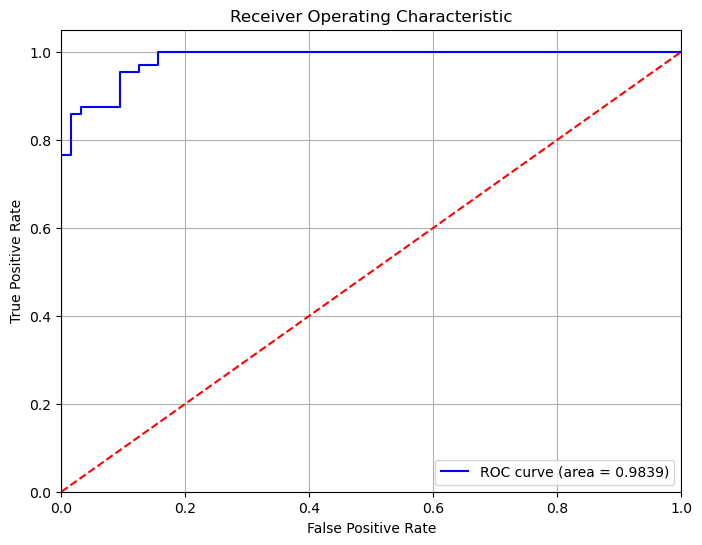

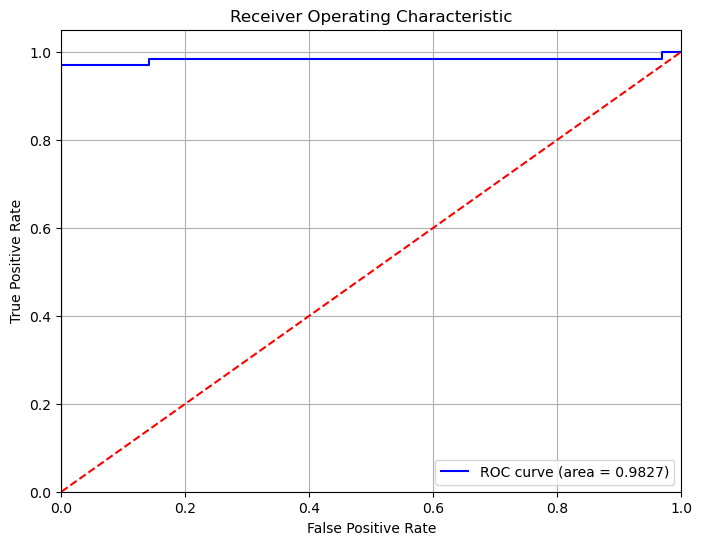

In [24]:
model, model_name = resnet.resnet32(num_classes=100)
model.to(device)
model = load_model_param(model, model_name)
evaluate_method(model, model_name, "fusion",  batch_limit=2)
# evaluate_method(model, model_name, "odin", batch_limit=2)
# evaluate_method(model, model_name, "mal", batch_limit=2)

Detection Method : fusion
Using downloaded and verified file: ./data\test_32x32.mat
Files already downloaded and verified
ID and OOD dataset load complete.
OOD
Adversarial Attack
setting parameters for standard version
using standard version including apgd-ce, apgd-t, fab-t, square.
initial accuracy: 71.88%
apgd-ce - 1/1 - 21 out of 46 successfully perturbed
robust accuracy after APGD-CE: 39.06% (total time 1.0 s)
apgd-t - 1/1 - 0 out of 25 successfully perturbed
robust accuracy after APGD-T: 39.06% (total time 11.0 s)
fab-t - 1/1 - 0 out of 25 successfully perturbed
robust accuracy after FAB-T: 39.06% (total time 30.6 s)
square - 1/1 - 0 out of 25 successfully perturbed
robust accuracy after SQUARE: 39.06% (total time 68.0 s)
max L2 perturbation: 59.08546, nan in tensor: 0, max: 2.02535, min: -1.89747
robust accuracy: 39.06%
OOD
Adversarial Attack
setting parameters for standard version
using standard version including apgd-ce, apgd-t, fab-t, square.
initial accuracy: 75.00%
apgd-ce -

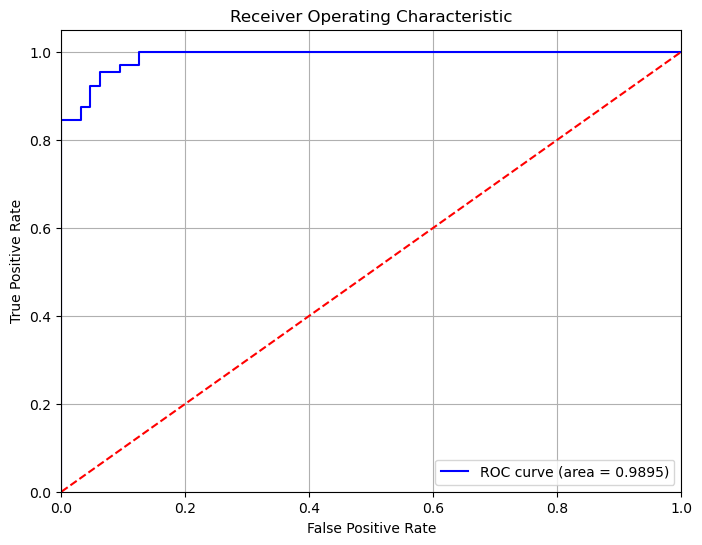

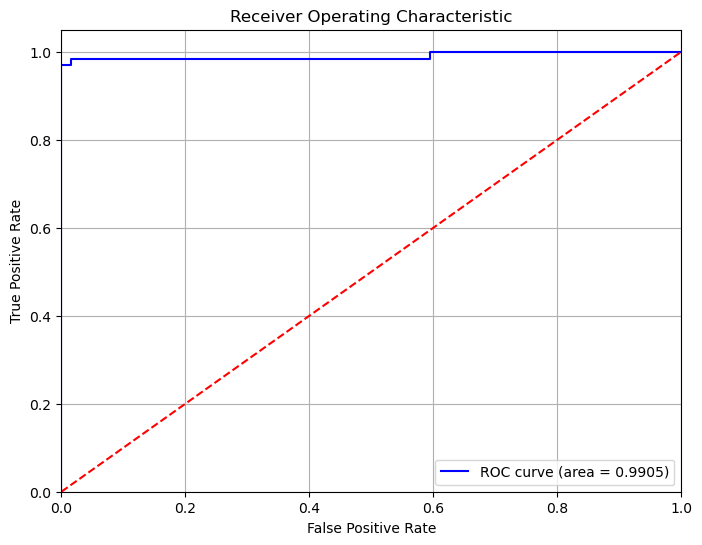

In [26]:
model, model_name = resnet.resnet56(num_classes=100)
model.to(device)
model = load_model_param(model, model_name)
evaluate_method(model, model_name, "fusion", batch_limit=2)
# evaluate_method(model, model_name, "odin", batch_limit=2)
# evaluate_method(model, model_name, "mal", batch_limit=2)

Detection Method : fusion
Using downloaded and verified file: ./data\test_32x32.mat
Files already downloaded and verified
ID and OOD dataset load complete.
OOD
Adversarial Attack
setting parameters for standard version
using standard version including apgd-ce, apgd-t, fab-t, square.
initial accuracy: 65.62%
apgd-ce - 1/1 - 20 out of 42 successfully perturbed
robust accuracy after APGD-CE: 34.38% (total time 0.4 s)
apgd-t - 1/1 - 0 out of 22 successfully perturbed
robust accuracy after APGD-T: 34.38% (total time 3.7 s)
fab-t - 1/1 - 0 out of 22 successfully perturbed
robust accuracy after FAB-T: 34.38% (total time 10.9 s)
square - 1/1 - 1 out of 22 successfully perturbed
robust accuracy after SQUARE: 32.81% (total time 30.5 s)
max L2 perturbation: 59.08546, nan in tensor: 0, max: 2.02535, min: -1.89747
robust accuracy: 32.81%
OOD
Adversarial Attack
setting parameters for standard version
using standard version including apgd-ce, apgd-t, fab-t, square.
initial accuracy: 71.88%
apgd-ce - 

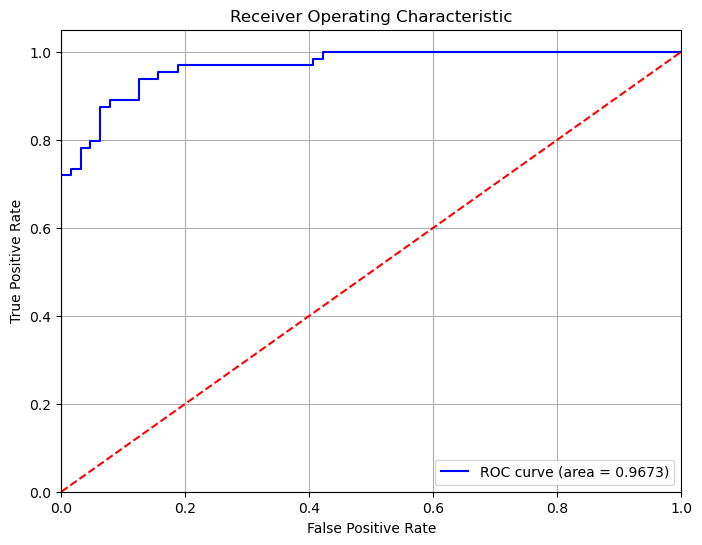

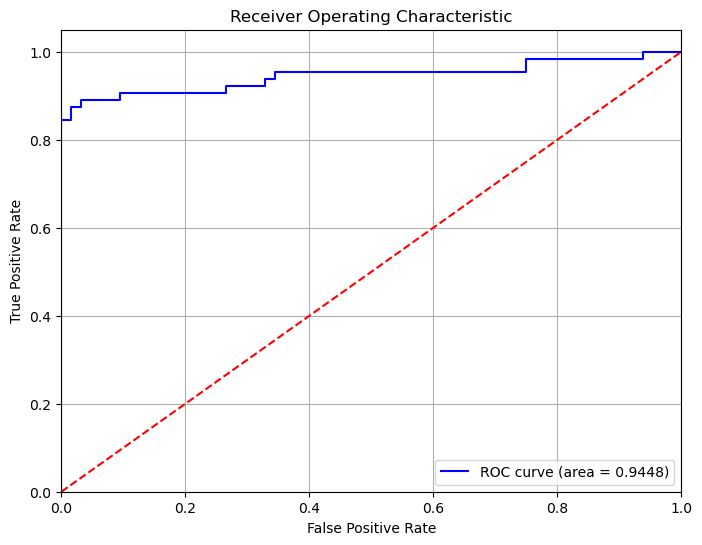

In [27]:
model, model_name = resnet.resnet8x4(num_classes=100)
model.to(device)
model = load_model_param(model, model_name)
evaluate_method(model, model_name, "fusion", batch_limit=2)
# evaluate_method(model, model_name, "odin", batch_limit=2)
# evaluate_method(model, model_name, "mal", batch_limit=2)

Detection Method : fusion
Using downloaded and verified file: ./data\test_32x32.mat
Files already downloaded and verified
ID and OOD dataset load complete.
OOD
Adversarial Attack
setting parameters for standard version
using standard version including apgd-ce, apgd-t, fab-t, square.
initial accuracy: 75.00%
apgd-ce - 1/1 - 15 out of 48 successfully perturbed
robust accuracy after APGD-CE: 51.56% (total time 0.9 s)
apgd-t - 1/1 - 1 out of 33 successfully perturbed
robust accuracy after APGD-T: 50.00% (total time 8.7 s)
fab-t - 1/1 - 0 out of 32 successfully perturbed
robust accuracy after FAB-T: 50.00% (total time 24.6 s)
square - 1/1 - 1 out of 32 successfully perturbed
robust accuracy after SQUARE: 48.44% (total time 54.8 s)
max L2 perturbation: 52.16636, nan in tensor: 0, max: 2.02535, min: -1.89747
robust accuracy: 48.44%
OOD
Adversarial Attack
setting parameters for standard version
using standard version including apgd-ce, apgd-t, fab-t, square.
initial accuracy: 76.56%
apgd-ce - 

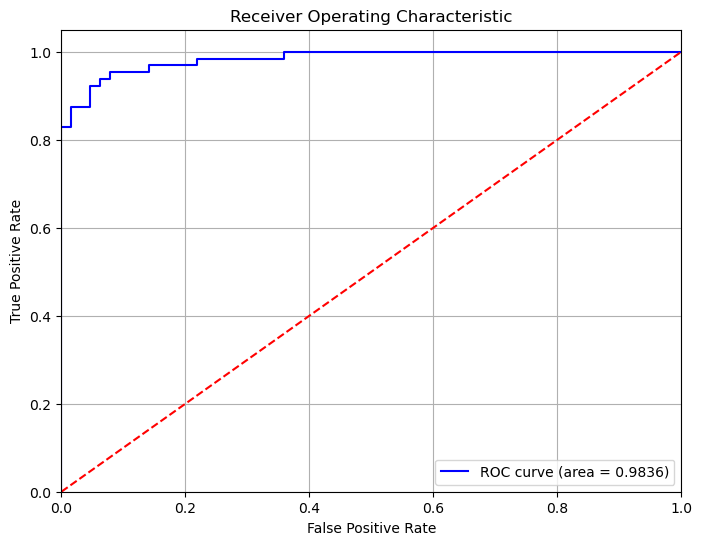

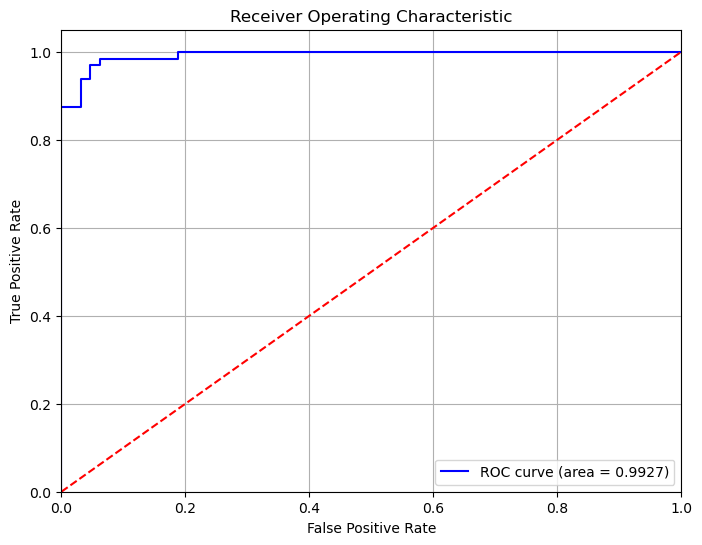

In [28]:
from models import wrn

model, model_name = wrn.wrn_40_2(num_classes=100)
model.to(device)
model = load_model_param(model, model_name)
evaluate_method(model, model_name, "fusion", batch_limit=2)
# evaluate_method(model, model_name, "odin", batch_limit=2)
# evaluate_method(model, model_name, "mal", batch_limit=2)

Detection Method : fusion
Using downloaded and verified file: ./data\test_32x32.mat
Files already downloaded and verified
ID and OOD dataset load complete.
OOD
Adversarial Attack
setting parameters for standard version
using standard version including apgd-ce, apgd-t, fab-t, square.
initial accuracy: 75.00%
apgd-ce - 1/1 - 21 out of 48 successfully perturbed
robust accuracy after APGD-CE: 42.19% (total time 0.8 s)
apgd-t - 1/1 - 0 out of 27 successfully perturbed
robust accuracy after APGD-T: 42.19% (total time 8.2 s)
fab-t - 1/1 - 0 out of 27 successfully perturbed
robust accuracy after FAB-T: 42.19% (total time 22.8 s)
square - 1/1 - 1 out of 27 successfully perturbed
robust accuracy after SQUARE: 40.62% (total time 53.7 s)
max L2 perturbation: 63.76080, nan in tensor: 0, max: 2.02535, min: -1.89747
robust accuracy: 40.62%
OOD
Adversarial Attack
setting parameters for standard version
using standard version including apgd-ce, apgd-t, fab-t, square.
initial accuracy: 73.44%
apgd-ce - 

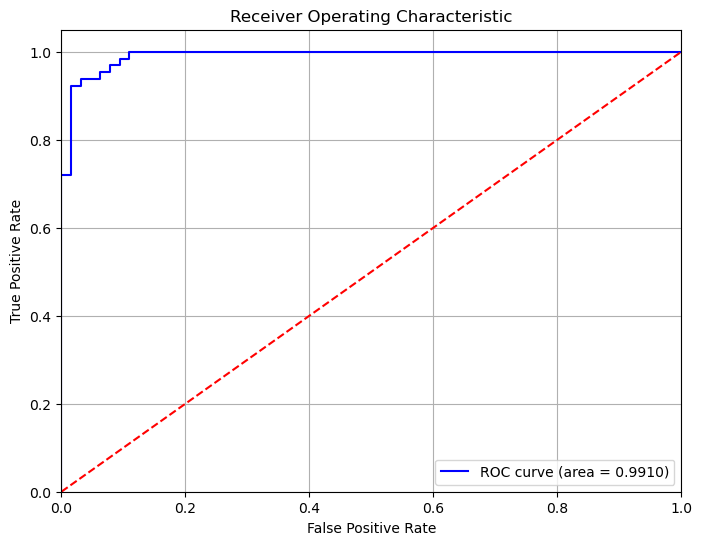

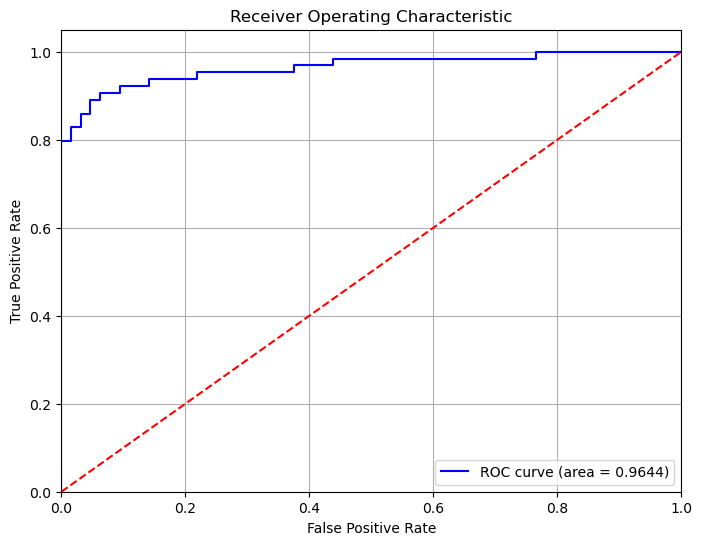

In [29]:
model, model_name = wrn.wrn_16_1(num_classes=100)
model.to(device)
model = load_model_param(model, model_name)
evaluate_method(model, model_name, "fusion", batch_limit=2)
# evaluate_method(model, model_name, "odin", batch_limit=2)
# evaluate_method(model, model_name, "mal", batch_limit=2)

Detection Method : fusion
Using downloaded and verified file: ./data\test_32x32.mat
Files already downloaded and verified
ID and OOD dataset load complete.
OOD
Adversarial Attack
setting parameters for standard version
using standard version including apgd-ce, apgd-t, fab-t, square.
initial accuracy: 73.44%
apgd-ce - 1/1 - 19 out of 47 successfully perturbed
robust accuracy after APGD-CE: 43.75% (total time 0.5 s)
apgd-t - 1/1 - 0 out of 28 successfully perturbed
robust accuracy after APGD-T: 43.75% (total time 4.9 s)
fab-t - 1/1 - 0 out of 28 successfully perturbed
robust accuracy after FAB-T: 43.75% (total time 15.3 s)
square - 1/1 - 0 out of 28 successfully perturbed
robust accuracy after SQUARE: 43.75% (total time 37.7 s)
max L2 perturbation: 59.08546, nan in tensor: 0, max: 2.02535, min: -1.89747
robust accuracy: 43.75%
OOD
Adversarial Attack
setting parameters for standard version
using standard version including apgd-ce, apgd-t, fab-t, square.
initial accuracy: 71.88%
apgd-ce - 

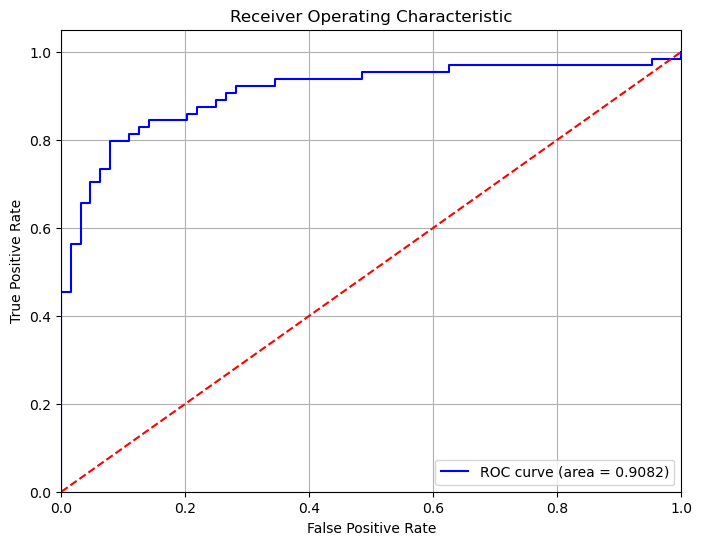

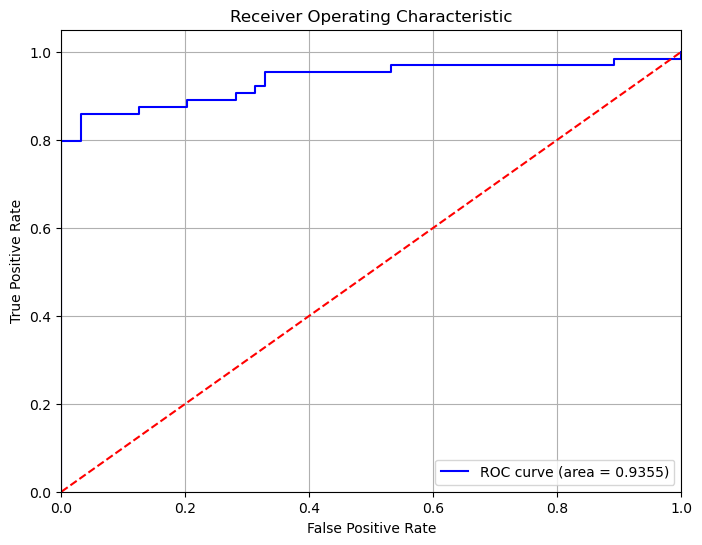

In [30]:
from models import vgg
model, model_name = vgg.vgg13(num_classes=100)
model.to(device)
model = load_model_param(model, model_name)
evaluate_method(model, model_name, "fusion", batch_limit=2)
# evaluate_method(model, model_name, "odin", batch_limit=2)
# evaluate_method(model, model_name, "mal", batch_limit=2)